In [1]:
# === SEL 1: SETUP & FOLDER ===
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Konfigurasi Path (Relative Path)
BASE_DIR = 'project'
DATA_DIR = os.path.join(BASE_DIR, 'data')
MODELS_DIR = os.path.join(BASE_DIR, 'models')
IMAGES_DIR = os.path.join(BASE_DIR, 'images', 'r')
NOTEBOOKS_DIR = os.path.join(BASE_DIR, 'notebooks')
SRC_DIR = os.path.join(BASE_DIR, 'src')

# Membuat folder otomatis
dirs_to_create = [DATA_DIR, MODELS_DIR, IMAGES_DIR, NOTEBOOKS_DIR, SRC_DIR]
for d in dirs_to_create:
    os.makedirs(d, exist_ok=True)

# Membuat file pelengkap (dummy)
with open(os.path.join(BASE_DIR, 'requirements.txt'), 'w') as f:
    f.write('pandas\nnumpy\nscikit-learn\ntensorflow\nbeautifulsoup4\nmatplotlib\nseaborn')
with open(os.path.join(BASE_DIR, '.gitignore'), 'w') as f:
    f.write('data/\nmodels/\n__pycache__/')
with open(os.path.join(BASE_DIR, 'README.md'), 'w') as f:
    f.write('# Proyek Klasifikasi Gender Aktor\nPrediksi gender berdasarkan nama aktor.')

print(f"[SUKSES] Struktur folder '{BASE_DIR}/' berhasil dibuat.")
print(f"[INSTRUKSI] Sekarang upload file 'actors.html' ke folder '{DATA_DIR}' di panel kiri.")

[SUKSES] Struktur folder 'project/' berhasil dibuat.
[INSTRUKSI] Sekarang upload file 'actors.html' ke folder 'project/data' di panel kiri.


In [3]:
# === SEL 2: LOAD & PARSING DATA (PERBAIKAN) ===
dataset_path = os.path.join(DATA_DIR, 'actors.html')

if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"File tidak ditemukan di {dataset_path}. Mohon upload 'actors.html' ke folder project/data/ terlebih dahulu!")

print(f"[INFO] Membaca file: {dataset_path}")

data_rows = []

with open(dataset_path, 'r', encoding='latin-1') as f:
    for line in f:
        # Kita cari baris yang dimulai dengan tag baris tabel
        if line.strip().startswith('<tr><td>'):
            # Teknik Split Manual: Memecah baris berdasarkan tag '<td>'
            # Format: <tr><td> Name<td> Dates<td> FName<td> GName<td> Gender<td> ...
            parts = line.split('<td>')

            # Pastikan baris memiliki cukup kolom (parts[0] adalah '<tr>', jadi data mulai index 1)
            if len(parts) > 5:
                name = parts[1].strip()   # Kolom 1: Nama
                gender = parts[5].strip() # Kolom 5: Gender

                # Kolom 8 biasanya Role, tapi kita handle jika index error
                role = parts[8].strip() if len(parts) > 8 else "Unknown"

                # Filter hanya Gender M & F
                if gender in ['M', 'F']:
                    data_rows.append({
                        'name': name,
                        'gender': gender,
                        'role': role
                    })

df = pd.DataFrame(data_rows)
print(f"[SUKSES] Data berhasil dimuat. Total sampel: {len(df)}")
print(df.head())

[INFO] Membaca file: project/data/actors.html
[SUKSES] Data berhasil dimuat. Total sampel: 6617
             name gender                             role
0    Willie Aames      M                              RU:
1      Bud Abbott      M                       R:straight
2  Diahnne Abbott      F                           R:sexy
3   George Abbott      M           R:playwright, producer
4     John Abbott      M  R:staring eyes, eccentric parts


[INFO] Menjalankan EDA...


/tmp/ipython-input-567276317.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='gender', palette='viridis')


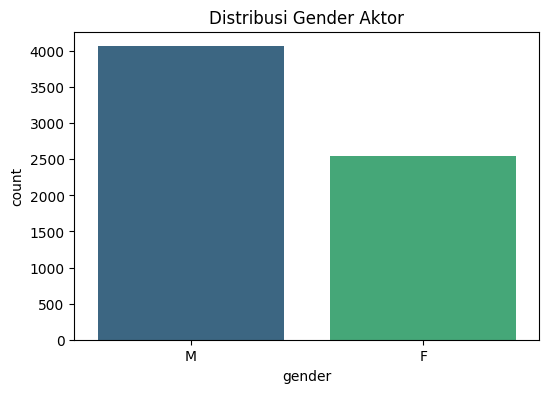

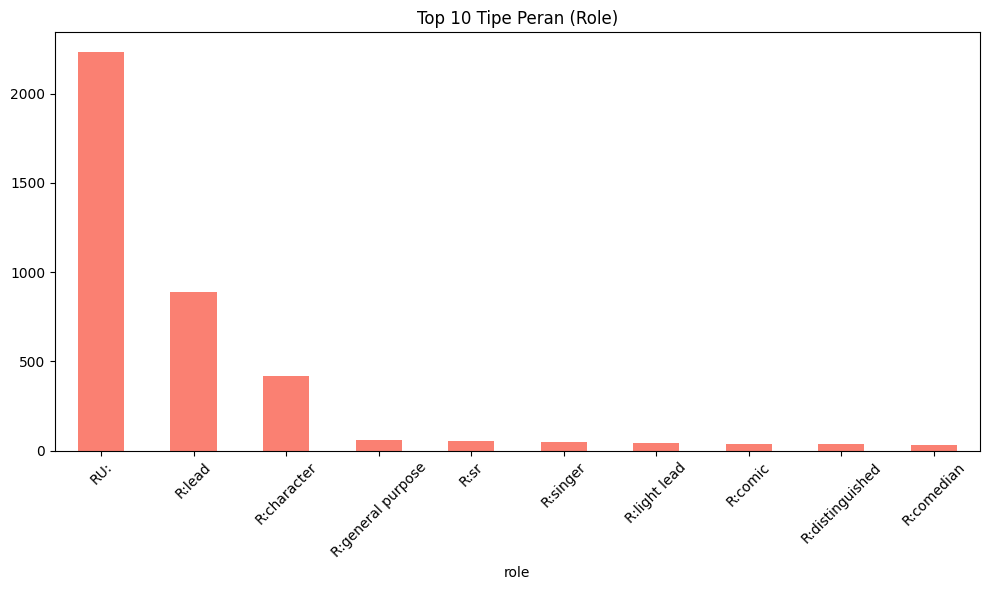

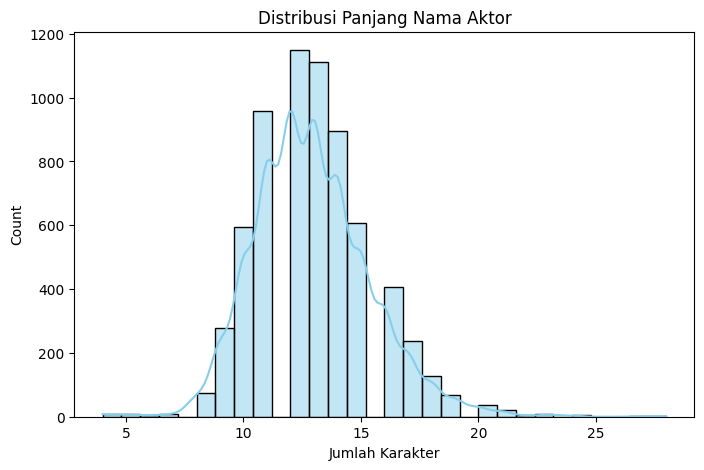

[INFO] Gambar visualisasi tersimpan di folder: project/images/r


In [4]:
# === SEL 3: EXPLORATORY DATA ANALYSIS (EDA) ===
print("[INFO] Menjalankan EDA...")

# 1. Distribusi Gender
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='gender', palette='viridis')
plt.title('Distribusi Gender Aktor')
plt.savefig(os.path.join(IMAGES_DIR, '1_distribusi_gender.png'))
plt.show()

# 2. Top 10 Role
plt.figure(figsize=(10, 6))
df['role'].value_counts().head(10).plot(kind='bar', color='salmon')
plt.title('Top 10 Tipe Peran (Role)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, '2_top_roles.png'))
plt.show()

# 3. Distribusi Panjang Nama
df['name_len'] = df['name'].apply(len)
plt.figure(figsize=(8, 5))
sns.histplot(df['name_len'], bins=30, kde=True, color='skyblue')
plt.title('Distribusi Panjang Nama Aktor')
plt.xlabel('Jumlah Karakter')
plt.savefig(os.path.join(IMAGES_DIR, '3_panjang_nama.png'))
plt.show()

print(f"[INFO] Gambar visualisasi tersimpan di folder: {IMAGES_DIR}")

In [5]:
# === SEL 4: PREPROCESSING ===
# Fitur: Nama, Target: Gender
X = df['name'].values
y = df['gender'].values

# Encode Label: F -> 0, M -> 1
le = LabelEncoder()
y_enc = le.fit_transform(y)
print(f"[INFO] Encoding: {le.classes_}")

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42)

print(f"[INFO] Data Split -> Train: {len(X_train)}, Test: {len(X_test)}")

[INFO] Encoding: ['F' 'M']
[INFO] Data Split -> Train: 5293, Test: 1324


In [6]:
# === SEL 5: TRAINING MODEL 1 (BASELINE) ===
print("--- Model 1: Dummy Classifier (Baseline) ---")

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)

acc_dummy = accuracy_score(y_test, y_pred_dummy)
print(f"Akurasi Baseline: {acc_dummy:.4f}")

# Simpan Model
with open(os.path.join(MODELS_DIR, 'model_baseline.pkl'), 'wb') as f:
    pickle.dump(dummy_clf, f)

--- Model 1: Dummy Classifier (Baseline) ---
Akurasi Baseline: 0.5899


In [7]:
# === SEL 6: TRAINING MODEL 2 (RANDOM FOREST) ===
print("--- Model 2: Random Forest (TF-IDF) ---")

# Ekstraksi fitur teks (N-gram karakter)
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 3), max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Training RF
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluasi
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Akurasi Random Forest: {acc_rf:.4f}")
print("\nClassification Report RF:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# Simpan Model & Vectorizer
with open(os.path.join(MODELS_DIR, 'model_rf.pkl'), 'wb') as f:
    pickle.dump((vectorizer, rf_model), f)

--- Model 2: Random Forest (TF-IDF) ---
Akurasi Random Forest: 0.8927

Classification Report RF:
              precision    recall  f1-score   support

           F       0.90      0.83      0.86       543
           M       0.89      0.94      0.91       781

    accuracy                           0.89      1324
   macro avg       0.89      0.88      0.89      1324
weighted avg       0.89      0.89      0.89      1324



In [8]:
# === SEL 7: TRAINING MODEL 3 (DEEP LEARNING - CNN) ===
print("--- Model 3: Deep Learning (CNN 1D) ---")

# Konfigurasi Tokenizer
MAX_LEN = 50  # Panjang maksimal nama
tokenizer = Tokenizer(char_level=True) # Tokenisasi per karakter
tokenizer.fit_on_texts(X_train)

# Konversi teks ke urutan angka
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding agar panjang input sama
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

vocab_size = len(tokenizer.word_index) + 1

# Arsitektur Model CNN
model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=32, input_length=MAX_LEN),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # Output biner (0/1)
])

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training
print("[INFO] Memulai training CNN...")
history = model_cnn.fit(
    X_train_pad, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    verbose=1 # Menampilkan log per epoch
)

# Evaluasi
loss, acc_cnn = model_cnn.evaluate(X_test_pad, y_test, verbose=0)
print(f"\nAkurasi CNN: {acc_cnn:.4f}")

# Simpan Model
model_cnn.save(os.path.join(MODELS_DIR, 'model_cnn.h5'))

--- Model 3: Deep Learning (CNN 1D) ---
[INFO] Memulai training CNN...
Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6193 - loss: 0.6601 - val_accuracy: 0.7576 - val_loss: 0.5156
Epoch 2/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7811 - loss: 0.4855 - val_accuracy: 0.7832 - val_loss: 0.4484
Epoch 3/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7977 - loss: 0.4537 - val_accuracy: 0.7976 - val_loss: 0.4241
Epoch 4/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8016 - loss: 0.4328 - val_accuracy: 0.8112 - val_loss: 0.4142
Epoch 5/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8194 - loss: 0.4162 - val_accuracy: 0.8150 - val_loss: 0.3999
Epoch 6/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8231 - loss: 0.4045 - val_accuracy: 0.8331 - val_loss: 0.3809
Epoch 7/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8381 - loss: 0.3831 - val_accuracy: 0.8391 - val_loss: 0.3728
Epoch 8/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8434 - loss: 0.3681 - val_accuracy: 0.8293 - val


Akurasi CNN: 0.8573


In [9]:
# === SEL 8: HASIL EVALUASI AKHIR ===
results = {
    'Baseline': acc_dummy,
    'Random Forest': acc_rf,
    'CNN (Deep Learning)': acc_cnn
}

print("\n==========================================")
print("       REKAPITULASI HASIL MODEL          ")
print("==========================================")
print(f"{'Model':<25} | {'Akurasi':<10}")
print("-" * 40)

for model_name, acc in results.items():
    print(f"{model_name:<25} | {acc:.4f}")

best_model = max(results, key=results.get)
print("-" * 40)
print(f"KESIMPULAN: Model terbaik adalah {best_model}")
print(f"[INFO] Semua file model tersimpan di: {MODELS_DIR}")


       REKAPITULASI HASIL MODEL          
Model                     | Akurasi   
----------------------------------------
Baseline                  | 0.5899
Random Forest             | 0.8927
CNN (Deep Learning)       | 0.8573
----------------------------------------
KESIMPULAN: Model terbaik adalah Random Forest
[INFO] Semua file model tersimpan di: project/models
